In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.decomposition import PCA

In [2]:
df = pd.read_excel("/Users/alsabbaghs/Downloads/DryBeanDataset/Dry_Bean_Dataset.xlsx")
df.head()
df["Class"].value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [3]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [ ]:
X = df.drop("Class", axis = 1)
Y = df["Class"]

scaler = StandardScaler()
data_cluster = scaler.fit_transform(X)
Y1 = Y.replace({"DERMASON": 1, "SIRA": 2, "SEKER": 6, "HOROZ": 4, "CALI": 5, "BARBUNYA": 0, "BOMBAY": 3})

In [ ]:
kmeans = KMeans(n_clusters = 7, random_state = 0)
kmeans.fit(data_cluster)
Y_predict = kmeans.predict(data_cluster)
labels = kmeans.labels_

cm = confusion_matrix(Y1, labels)
accuracy(cm)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7864962162956433

In [ ]:
cm

array([[1142,    0,  114,    0,    8,   40,   18],
       [   0, 2912,  499,    0,    7,   13,  115],
       [   5,  191, 2326,    0,   63,   27,   24],
       [   1,    0,    0,  520,    0,    1,    0],
       [  29,    2,   49,    0, 1661,  187,    0],
       [1303,    0,   25,    0,   30,  270,    2],
       [   0,   52,   98,    0,    0,    3, 1874]])

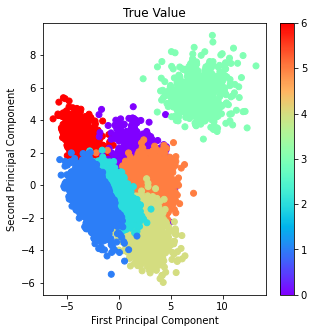

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_cluster)

fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = Y1, cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('True Value')
plt.colorbar(scatter)
plt.show()

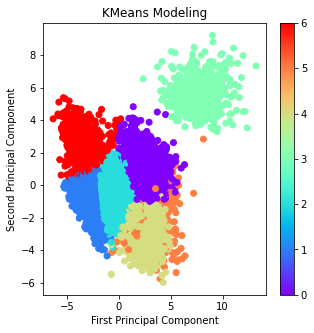

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = labels, cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KMeans Modeling')
plt.colorbar(scatter)
plt.show()



In [ ]:
df["Class"] = df["Class"].replace({"DERMASON": 1, "SIRA": 2, "SEKER": 6, "HOROZ": 4, "CALI": 5, "BARBUNYA": 0, "BOMBAY": 3})

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("Class", axis = 1), df["Class"], test_size = 0.2857, random_state = 42, shuffle = True)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
#print(Y_train)

(9722, 16) (9722,) (3889, 16) (3889,)


In [ ]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range



In [ ]:
grid = [[6, 6], [6, 8], [4, 6], [5, 7], [10, 10], [5, 5], [15, 15]]
max_m_dsitance = 7
max_learning_rate = 0.5
max_steps = 75000
loop = [500, 1000, 5000, 10000, 20000, 50000]

#num_nurons = 7 * np.sqrt(X_train.shape[0])
#grid_size = ceil(np.sqrt(num_nurons))
#print(grid_size)

In [ ]:
#mian function

train_x_norm = minmax_scaler(X_train) # normalisation
data = minmax_scaler(X_test) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)


# start training iterations

for j in range(len(grid)):
  num_rows = grid[j][0]
  num_cols = grid[j][1]
  som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
  print("Grid " f"{num_rows} x {num_cols}:")
  for step in range(max_steps):
    #if (step+1) % 1000 == 0:
      #print("Iteration: ", step+1) # print out the current iteration for every 1k
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
      for col in range(num_cols):
        if m_distance([row,col],winner) <= neighbourhood_range:
          som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight
    for i in loop:
      if step == i:
        label_data = np.array(Y_train)
        map = np.empty(shape=(num_rows, num_cols), dtype=object)

        for row in range(num_rows):
          for col in range(num_cols):
            map[row][col] = [] # empty list to store the label

        for t in range(train_x_norm.shape[0]):
          #if (t+1) % 1000 == 0:
            #print("sample data: ", t+1)
          winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
          map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron
        
        label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
        for row in range(num_rows):
          for col in range(num_cols):
            label_list = map[row][col]
            if len(label_list)==0:
              label = 2
            else:
              label = max(label_list, key=label_list.count)
            label_map[row][col] = label
        
        winner_labels = []

        for t in range(data.shape[0]):
          winner = winning_neuron(data, t, som, num_rows, num_cols)
          row = winner[0]
          col = winner[1]
          predicted = label_map[row][col]
          winner_labels.append(predicted)

        print("Loop " f"{i}: "  "Accuracy: ",accuracy_score(Y_test, np.array(winner_labels)))

#print("SOM training completed")

Grid 6 x 6:
Loop 500: Accuracy:  0.6466958086911803
Loop 1000: Accuracy:  0.4098740035998971
Loop 5000: Accuracy:  0.6598097197222936
Loop 10000: Accuracy:  0.4823862175366418
Loop 20000: Accuracy:  0.6178966315248136
Loop 50000: Accuracy:  0.7891488814605297
Grid 6 x 8:
Loop 500: Accuracy:  0.6222679352018514
Loop 1000: Accuracy:  0.6886088968886603
Loop 5000: Accuracy:  0.5993828747750064
Loop 10000: Accuracy:  0.6004114168166624
Loop 20000: Accuracy:  0.6916945230136282
Loop 50000: Accuracy:  0.7804062741064541
Grid 4 x 6:
Loop 500: Accuracy:  0.4289020313705323
Loop 1000: Accuracy:  0.4584726150681409
Loop 5000: Accuracy:  0.4214451015685266
Loop 10000: Accuracy:  0.43815890974543587
Loop 20000: Accuracy:  0.5929544870146567
Loop 50000: Accuracy:  0.7580354847004371
Grid 5 x 7:
Loop 500: Accuracy:  0.5947544355875546
Loop 1000: Accuracy:  0.5785548984314733
Loop 5000: Accuracy:  0.5919259449730008
Loop 10000: Accuracy:  0.5057855489843147
Loop 20000: Accuracy:  0.6461815376703522
L

In [ ]:
num_rows = 15
num_cols = 15
max_m_dsitance = 7
max_learning_rate = 0.5
max_steps = 50000

#num_nurons = 7 * np.sqrt(X_train.shape[0])
#grid_size = ceil(np.sqrt(num_nurons))
#print(grid_size)

In [ ]:
#mian function

train_x_norm = minmax_scaler(X_train) # normalisation
data = minmax_scaler(X_test) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
SOM training completed


In [ ]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)


for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  #print(winner)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron


sample data:  1000
sample data:  2000
sample data:  3000
sample data:  4000
sample data:  5000
sample data:  6000
sample data:  7000
sample data:  8000
sample data:  9000


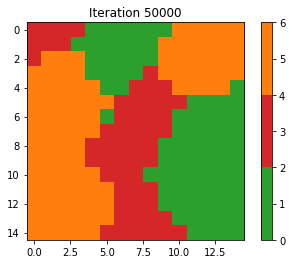

In [ ]:
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(X_test) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(Y_test, np.array(winner_labels)))

Accuracy:  0.892517356646953
